In [85]:
import pandas as pd
import xgboost as xgb 
import shap
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import PredictionErrorDisplay
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll import scope
from sklearn.model_selection import cross_val_score
%matplotlib inline

In [87]:
dataset = pd.read_csv("bmw_pricing_challenge.csv")

In [88]:
profile = ProfileReport(dataset, title="Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [89]:
dataset.loc[dataset["price"] > 80000]

,maker_key,model_key,mileage,engine_power,registration_date,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,sold_at
90,BMW,i8,12402,170,2016-01-01,hybrid_petrol,grey,coupe,True,True,False,False,False,False,False,True,95200,2018-04-01
4146,BMW,X6 M,2970,423,2016-04-01,petrol,red,suv,True,True,True,False,False,False,True,True,82400,2018-04-01
4684,BMW,X4,103222,140,2014-08-01,diesel,grey,suv,True,True,False,False,True,False,True,True,142800,2018-08-01
4753,BMW,X3,72515,135,2013-03-01,diesel,blue,suv,False,False,True,False,False,False,False,True,178500,2018-08-01


In [90]:
y_data = dataset["price"]
X_data = dataset.drop(columns=["price", "maker_key"])
train_X, test_X, train_y, test_y = train_test_split(
    X_data, y_data, test_size=0.2, random_state=42
)

In [91]:
class DropDateFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        assert len(columns) == 2
        self.columns = columns
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[self.columns] = X[self.columns].apply(pd.to_datetime)
        X["age"] = X[self.columns[0]] - X[self.columns[1]]
        X["age"] = X["age"].dt.days
        X = X.drop(columns=self.columns)
        return X


class BMWModelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.encoder = OrdinalEncoder(
            handle_unknown="use_encoded_value",
            unknown_value=-1,
            min_frequency=50,
            encoded_missing_value=-2,
        )

    def fit(self, X, y=None):
        self.encoder.fit(X[self.columns])
        return self

    def transform(self, X):
        X[self.columns] = self.encoder.transform(X[self.columns])
        return X


preprocessing_pipe = Pipeline(
    [
        ("ager", DropDateFeatures(columns=["sold_at", "registration_date"])),
        (
            "encoder",
            BMWModelEncoder(columns=["model_key", "fuel", "paint_color", "car_type"]),
        ),
    ]
)

In [92]:
tranformed_train_X = preprocessing_pipe.fit_transform(train_X)
tranformed_train_X

,model_key,mileage,engine_power,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,age
1215,8.0,119515,135,0.0,3.0,1.0,False,True,False,False,True,False,True,True,1430
432,5.0,234365,135,0.0,0.0,1.0,True,True,False,False,True,False,True,True,1127
4244,12.0,77356,105,0.0,0.0,5.0,False,True,False,False,False,False,True,False,1946
289,3.0,181297,105,0.0,2.0,1.0,False,True,False,False,True,True,True,True,1341
2585,5.0,144089,137,1.0,0.0,3.0,True,True,False,False,True,False,True,False,1918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4426,11.0,58189,100,0.0,0.0,5.0,False,True,False,False,False,False,True,False,2252
466,10.0,178174,190,0.0,1.0,1.0,True,True,False,False,True,False,True,True,2102
3092,14.0,39250,317,1.0,0.0,3.0,True,True,False,False,False,True,True,True,912
3772,12.0,75065,140,0.0,5.0,5.0,False,False,False,False,False,False,False,True,1400


In [93]:
search_space = {
    "learning_rate": hp.loguniform("learning_rate", -7, 0),
    "max_depth": scope.int(hp.uniform("max_depth", 1, 100)),
    "min_child_weight": hp.loguniform("min_child_weight", -2, 3),
    "subsample": hp.uniform("subsample", 0.5, 1),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
    "gamma": hp.loguniform("gamma", -10, 10),
    "alpha": hp.loguniform("alpha", -10, 10),
    "lambda": hp.loguniform("lambda", -10, 10),
    "objective": "reg:squarederror",
    "seed": 42,
}

In [94]:
def train_model(params):
    if "max_depth" in params:
        params["max_depth"] = int(
            params["max_depth"]
        )  # hyperopt supplies values as float but must be int
    if "min_child_weight" in params:
        params["min_child_weight"] = int(
            params["min_child_weight"]
        )  # hyperopt supplies values as float but must be int
    regressor = xgb.XGBRegressor(**params)
    score = cross_val_score(
        estimator=regressor, X=tranformed_train_X, y=train_y, scoring="r2", cv=5
    ).mean()
    return {"status": STATUS_OK, "loss": -score}

In [95]:
trials = Trials()
best_params = fmin(
    fn=train_model, space=search_space, algo=tpe.suggest, max_evals=300, trials=trials
)
if "max_depth" in best_params:
    best_params["max_depth"] = int(
        best_params["max_depth"]
    )  # hyperopt supplies values as float but must be int
if "min_child_weight" in best_params:
    best_params["min_child_weight"] = int(
        best_params["min_child_weight"]
    )  # hyperopt supplies values as float but must be int
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(tranformed_train_X, train_y)
model_pipeline = Pipeline(
    [("preprossesor", preprocessing_pipe), ("estimator", best_model)]
)

100%|██████████| 300/300 [05:32<00:00,  1.11s/trial, best loss: -0.8066892296445379]


In [96]:
predictions = model_pipeline.predict(test_X)

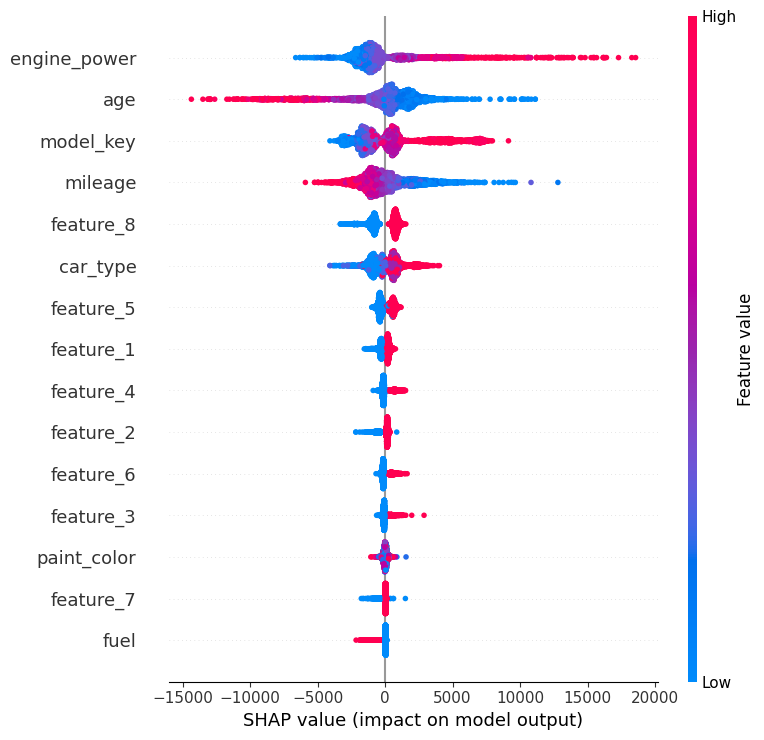

In [97]:
explainer = shap.Explainer(best_model)
shap_values = explainer(tranformed_train_X)
shap.summary_plot(shap_values, tranformed_train_X)

In [98]:
from sklearn.metrics import explained_variance_score

metrics_dict = {
    "explained_variance_score": explained_variance_score(test_y, predictions),
    "mean_squared_error": mean_squared_error(test_y, predictions),
    "r2_score": r2_score(test_y, predictions),
    "mean_absolute_error": mean_absolute_error(test_y, predictions),
}

In [99]:
metrics_dict

{'explained_variance_score': 0.8141129371214377,
 'mean_squared_error': 13212755.960619096,
 'r2_score': 0.814089849148484,
 'mean_absolute_error': 1894.7939519892043}

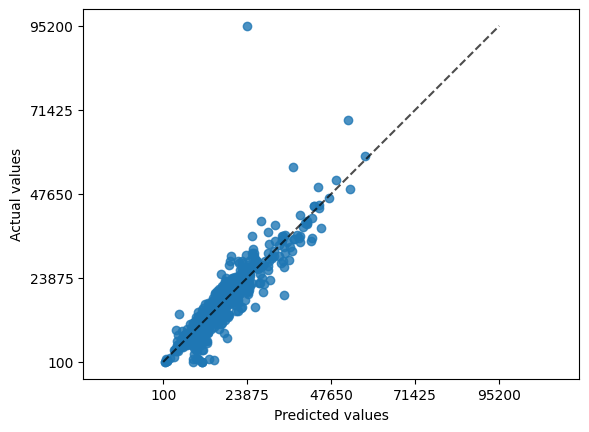

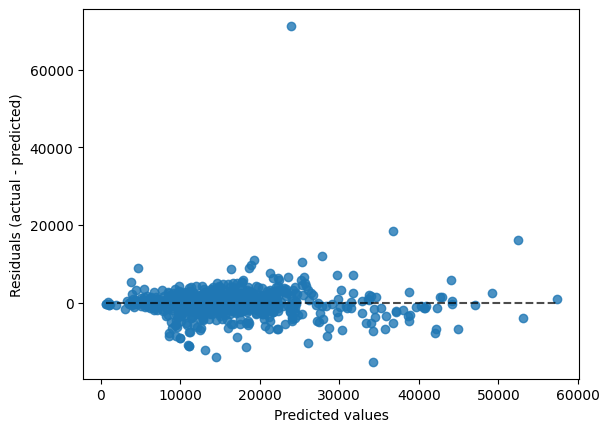

In [101]:
PredictionErrorDisplay.from_predictions(
    y_true=test_y, y_pred=predictions, kind="actual_vs_predicted"
).plot()